In [1]:
# Install necessary packages
!pip install pandas numpy matplotlib seaborn scipy statsmodels tqdm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from tqdm import tqdm
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

In [3]:
# create directories for plots and results if they do not exist
import os
os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [4]:
# Event Study Class
class EventStudy:
    
    def __init__(self, market_data, market_index='SP500', event_dates=None):
        self.data = market_data
        self.market_index = market_index
        
        if event_dates is not None:
            self.event_dates = pd.DatetimeIndex(event_dates)
        elif 'LastFOMCChange' in self.data.columns:
            self.event_dates = self.data[self.data['LastFOMCChange'].diff() != 0].index
        else:
            raise ValueError("Event dates must be provided or 'LastFOMCChange' column must exist in data")
        
        self._abnormal_returns = None
        self._cumulative_abnormal_returns = None
        self._test_results = None
    
    def run_event_study(self, assets, estimation_window=120, event_window=(-10, 20), 
                        market_model=True, include_event_period=False):
        """
        Run a complete event study analysis.
        """
        missing_assets = [asset for asset in assets if asset not in self.data.columns]
        if missing_assets:
            raise ValueError(f"The following assets are not in the data: {missing_assets}")
        
        asset_names = {
            'SP500': 'S&P 500',
            'NASDAQ': 'NASDAQ Composite',
            'DowJones': 'Dow Jones Industrial',
            'Russell2000': 'Russell 2000',
            'XLF': 'Financials',
            'XLK': 'Technology',
            'XLE': 'Energy',
            'XLV': 'Healthcare',
            'XLI': 'Industrials',
            'XLP': 'Consumer Staples',
            'XLY': 'Consumer Discretionary',
            'XLB': 'Materials',
            'XLRE': 'Real Estate',
            'XLU': 'Utilities',
            'XLC': 'Communication Services'
        }
        
        for asset in assets + [self.market_index]:
            return_col = f"{asset}_Return"
            if return_col not in self.data.columns:
                self.data[return_col] = self.data[asset].pct_change() * 100
        
        all_abnormal_returns = {}
        all_cumulative_abnormal_returns = {}
        all_test_results = {}
        
        event_days = list(range(event_window[0], event_window[1] + 1))
        
        for asset in assets:
            asset_return = f"{asset}_Return"
            market_return = f"{self.market_index}_Return"
            
            abnormal_returns = pd.DataFrame(index=event_days, columns=self.event_dates)
            
            for event_date in tqdm(self.event_dates, desc=f"Processing {asset_names.get(asset, asset)}"):
                try:
                    est_end = event_date - pd.Timedelta(days=1) if not include_event_period else event_date + pd.Timedelta(days=event_window[1])
                    est_start = est_end - pd.Timedelta(days=estimation_window)
                    
                    mask = (self.data.index >= est_start) & (self.data.index <= est_end)
                    estimation_data = self.data.loc[mask]
                    
                    if market_model and len(estimation_data) >= 30:  # Ensure enough data for regression
                        X = sm.add_constant(estimation_data[market_return])
                        model = OLS(estimation_data[asset_return], X).fit()
                        alpha, beta = model.params
                    else:
                        alpha = estimation_data[asset_return].mean()
                        beta = 0
                    
                    for day in event_days:
                        event_day = event_date + pd.Timedelta(days=day)
                        
                        if event_day in self.data.index:
                            if market_model:
                                market_ret = self.data.loc[event_day, market_return]
                                expected_return = alpha + beta * market_ret
                            else:
                                expected_return = alpha
                            
                            actual_return = self.data.loc[event_day, asset_return]
                            abnormal_return = actual_return - expected_return
                            
                            abnormal_returns.loc[day, event_date] = abnormal_return
                
                except Exception as e:
                    print(f"Error processing event {event_date} for {asset}: {str(e)}")
                    continue
            
            abnormal_returns['AAR'] = abnormal_returns.mean(axis=1)
            
            cumulative_abnormal_returns = abnormal_returns.copy()
            for col in cumulative_abnormal_returns.columns:
                cumulative_abnormal_returns[col] = abnormal_returns[col].cumsum()
            
            se = abnormal_returns.drop('AAR', axis=1).std(axis=1) / np.sqrt(len(self.event_dates))
            t_stats = abnormal_returns['AAR'] / se
            p_values = [2 * (1 - stats.t.cdf(abs(t), len(self.event_dates) - 1)) for t in t_stats]
            
            test_results = pd.DataFrame({
                'AAR': abnormal_returns['AAR'],
                'CAR': cumulative_abnormal_returns['AAR'],
                'SE': se,
                't-stat': t_stats,
                'p-value': p_values
            })
            test_results['Significant'] = test_results['p-value'] < 0.05
            
        
            all_abnormal_returns[asset] = abnormal_returns
            all_cumulative_abnormal_returns[asset] = cumulative_abnormal_returns
            all_test_results[asset] = test_results
        
        self._abnormal_returns = all_abnormal_returns
        self._cumulative_abnormal_returns = all_cumulative_abnormal_returns
        self._test_results = all_test_results
        self._asset_names = asset_names
        
        return all_cumulative_abnormal_returns
    
    def analyze_by_event_type(self, assets, event_types=None, event_window=(-10, 20)):
   
        if self._abnormal_returns is None:
            raise ValueError("Run event_study first before analyzing by event type")
        
        if event_types is None and 'RateChange' in self.data.columns:
            event_types = {
                'Rate Hikes': self.data['RateChange'] > 0,
                'Rate Cuts': self.data['RateChange'] < 0,
                'No Change': self.data['RateChange'] == 0
            }
        elif event_types is None:
            raise ValueError("event_types must be provided if 'RateChange' column is not in data")
        
        results_by_type = {}
        
        event_days = list(range(event_window[0], event_window[1] + 1))
        
        for asset in assets:
            if asset not in self._abnormal_returns:
                print(f"Skipping {asset} - not found in abnormal returns")
                continue
                
            abnormal_returns = self._abnormal_returns[asset].drop('AAR', axis=1).copy()
            
            asset_results = {}
            
            for event_type, condition in event_types.items():
                type_dates = []
                for date in abnormal_returns.columns:
                    if date in self.data.index and condition.loc[date]:
                        type_dates.append(date)
                
                if not type_dates:
                    print(f"No events found for {event_type} - skipping")
                    continue
                
                type_returns = abnormal_returns[type_dates].mean(axis=1)
                
                type_car = type_returns.cumsum()
                
                se = abnormal_returns[type_dates].std(axis=1) / np.sqrt(len(type_dates))
                t_stats = type_returns / se
                p_values = [2 * (1 - stats.t.cdf(abs(t), len(type_dates) - 1)) for t in t_stats]
                
                type_results = pd.DataFrame({
                    'AAR': type_returns,
                    'CAR': type_car,
                    'SE': se,
                    't-stat': t_stats,
                    'p-value': p_values,
                    'Significant': [p < 0.05 for p in p_values],
                    'N': len(type_dates)
                })
                
                asset_results[event_type] = type_results
            
            results_by_type[asset] = asset_results
        
        return results_by_type
    
    def plot_cumulative_abnormal_returns(self, assets, event_types=None, title=None, figsize=(14, 10)):
 
        if self._cumulative_abnormal_returns is None and event_types is None:
            raise ValueError("Run event_study first before plotting")
        
        if event_types is not None and self._abnormal_returns is None:
            raise ValueError("Run event_study first before analyzing by event type")
        
        try:
            plt.style.use('seaborn')
        except:
            plt.style.use('default')
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        
        asset_names = getattr(self, '_asset_names', {})
        
        fig, ax = plt.subplots(figsize=figsize, dpi=100)
        
        if event_types is None:
            for i, asset in enumerate(assets):
                if asset in self._cumulative_abnormal_returns:
                    car = self._cumulative_abnormal_returns[asset]['AAR']
                    ax.plot(car.index, car.values, label=asset_names.get(asset, asset),
                            linewidth=2.5, marker='o', markersize=4, alpha=0.8,
                            color=colors[i % len(colors)])
            
            ax.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=1.5)
            ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
            
            ax.axvspan(-0.5, 0.5, color='gray', alpha=0.1)
            
            ax.set_xlabel('Days Relative to FOMC Announcement', fontsize=14, fontweight='bold')
            ax.set_ylabel('Cumulative Abnormal Return (%)', fontsize=14, fontweight='bold')
            
            if title:
                ax.set_title(title, fontsize=16, fontweight='bold')
            else:
                ax.set_title('Cumulative Abnormal Returns Around FOMC Meetings', fontsize=16, fontweight='bold')
            
            ax.legend(loc='best', frameon=True, framealpha=0.9, fontsize=12, ncol=2)
            
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            
            ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
            
            max_car = -float('inf')
            min_car = float('inf')
            max_asset = None
            min_asset = None
            
            for i, asset in enumerate(assets):
                if asset in self._cumulative_abnormal_returns:
                    car = self._cumulative_abnormal_returns[asset]['AAR']
                    car_end = car.iloc[-1]
                    if car_end > max_car:
                        max_car = car_end
                        max_asset = asset
                    if car_end < min_car:
                        min_car = car_end
                        min_asset = asset
            
            if max_asset and min_asset:
                ax.annotate(f'Best: {asset_names.get(max_asset, max_asset)}',
                            xy=(event_window[1], max_car),
                            xytext=(event_window[1]-5, max_car+0.5),
                            arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8),
                            fontsize=10, color='green', fontweight='bold')
                
                ax.annotate(f'Worst: {asset_names.get(min_asset, min_asset)}',
                            xy=(event_window[1], min_car),
                            xytext=(event_window[1]-5, min_car-0.5),
                            arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=8),
                            fontsize=10, color='red', fontweight='bold')
            
        else:
            results = self.analyze_by_event_type(assets, event_types)
            
            line_styles = ['-', '--', '-.', ':']
            
            for i, asset in enumerate(assets[:1]):  # Just the first asset for clarity
                if asset not in results:
                    continue
                    
                asset_results = results[asset]
                
                for j, (event_type, data) in enumerate(asset_results.items()):
                    label = f"{event_type} (N={data['N'].iloc[0]})"
                    ax.plot(data.index, data['CAR'].values, 
                           label=label,
                           linewidth=2.5, marker='o', markersize=4, alpha=0.8,
                           color=colors[j % len(colors)])
                
                ax.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=1.5)
                ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
                
                ax.axvspan(-0.5, 0.5, color='gray', alpha=0.1)
                
                ax.set_xlabel('Days Relative to FOMC Announcement', fontsize=14, fontweight='bold')
                ax.set_ylabel('Cumulative Abnormal Return (%)', fontsize=14, fontweight='bold')
                
                if title:
                    ax.set_title(title, fontsize=16, fontweight='bold')
                else:
                    ax.set_title(f'Cumulative Abnormal Returns for {asset_names.get(asset, asset)} by Fed Decision Type', 
                               fontsize=16, fontweight='bold')
                
                ax.legend(loc='best', frameon=True, framealpha=0.9, fontsize=12)
                
                ax.xaxis.set_major_locator(MaxNLocator(integer=True))
                
                ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        
        fig.tight_layout()
        
        return fig
    
    def plot_aar_significance(self, assets, event_types=None, figsize=(14, 12)):
     
        if self._test_results is None and event_types is None:
            raise ValueError("Run event_study first before plotting significance")
        
        if event_types is not None and self._abnormal_returns is None:
            raise ValueError("Run event_study first before analyzing by event type")
        
        try:
            plt.style.use('seaborn')
        except:
            plt.style.use('default')
        
        asset_names = getattr(self, '_asset_names', {})
        
        fig, axes = plt.subplots(len(assets), 1, figsize=figsize, sharex=True, dpi=100)
        if len(assets) == 1:
            axes = [axes]
        
        if event_types is None:
            for i, asset in enumerate(assets):
                if asset not in self._test_results:
                    continue
                    
                ax = axes[i]
                results = self._test_results[asset]
                
                bars = ax.bar(results.index, results['AAR'], alpha=0.7, color='skyblue', width=0.8)
                
                significant = results[results['Significant']].index
                if len(significant) > 0:
                    for bar, idx in zip(bars, results.index):
                        if idx in significant:
                            bar.set_color('darkblue')
                            bar.set_alpha(1.0)
                
                ax.errorbar(results.index, results['AAR'], yerr=results['SE']*1.96, 
                           fmt='none', ecolor='black', capsize=3, alpha=0.5, linewidth=1)
                
                ax.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
                ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
                
                ax.axvspan(-0.5, 0.5, color='gray', alpha=0.1)
                
                ax.set_ylabel(f"{asset_names.get(asset, asset)}\nAAR (%)", fontsize=12, fontweight='bold')
                ax.set_title(f"Average Abnormal Returns for {asset_names.get(asset, asset)}", 
                            fontsize=14, fontweight='bold')
                
                ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
                
                for idx in significant:
                    value = results.loc[idx, 'AAR']
                    t_stat = results.loc[idx, 't-stat']
                    ax.annotate(f't={t_stat:.2f}*', 
                               xy=(idx, value),
                               xytext=(idx, value + 0.2 if value > 0 else value - 0.4),
                               fontsize=8, ha='center')
        else:
            results = self.analyze_by_event_type(assets, event_types)
            
            for i, asset in enumerate(assets):
                if asset not in results:
                    continue
                    
                ax = axes[i]
                asset_results = results[asset]
                
                event_types_list = list(asset_results.keys())
                bar_width = 0.8 / len(event_types_list)
                
                event_colors = {
                    'Rate Hikes': 'indianred',
                    'Rate Cuts': 'mediumseagreen',
                    'No Change': 'royalblue'
                }
                
                for j, (event_type, data) in enumerate(asset_results.items()):
                    positions = [x + (j - len(event_types_list)/2 + 0.5) * bar_width for x in data.index]
                    
                    color = event_colors.get(event_type, f"C{j}")
                    bars = ax.bar(positions, data['AAR'], width=bar_width, alpha=0.7, 
                                 label=f"{event_type} (N={data['N'].iloc[0]})",
                                 color=color)
                    
                    significant = data[data['Significant']].index
                    if len(significant) > 0:
                        sig_positions = [x + (j - len(event_types_list)/2 + 0.5) * bar_width for x in significant]
                        sig_values = data.loc[significant, 'AAR']
                        ax.bar(sig_positions, sig_values, width=bar_width, color=color, alpha=1.0)
                        
                        for pos, idx in zip(sig_positions, significant):
                            value = data.loc[idx, 'AAR']
                            ax.annotate('*', 
                                       xy=(pos, value),
                                       xytext=(pos, value + 0.1 if value > 0 else value - 0.2),
                                       fontsize=14, ha='center', fontweight='bold')
                
                ax.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
                ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
                
                ax.axvspan(-0.5, 0.5, color='gray', alpha=0.1)
                
                ax.set_ylabel(f"{asset_names.get(asset, asset)}\nAAR (%)", fontsize=12, fontweight='bold')
                ax.set_title(f"Average Abnormal Returns for {asset_names.get(asset, asset)} by Fed Decision Type", 
                            fontsize=14, fontweight='bold')
                
                if i == 0:
                    ax.legend(loc='best', frameon=True, framealpha=0.9, fontsize=10)
                
                ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        
        fig.text(0.5, 0.01, 'Days Relative to FOMC Announcement', ha='center', 
                 fontsize=14, fontweight='bold')
        
        fig.text(0.01, 0.01, '* Statistically significant at 5% level', 
                 fontsize=9, style='italic')
        
        plt.subplots_adjust(hspace=0.3)
        
        return fig
    
    def plot_all_indices_comparison(self, indices, event_window=(-10, 20), figsize=(14, 10)):
       
        if self._cumulative_abnormal_returns is None:
            raise ValueError("Run event_study first before plotting")
        
        try:
            plt.style.use('default')
        except:
            pass
        
        asset_names = getattr(self, '_asset_names', {})
        
        fig, ax = plt.subplots(figsize=figsize, dpi=100)
        
        index_colors = {
            'SP500': '#1f77b4',  # blue
            'NASDAQ': '#ff7f0e',  # orange
            'DowJones': '#2ca02c',  # green
            'Russell2000': '#d62728',  # red
        }
        
        for idx in indices:
            if idx in self._cumulative_abnormal_returns:
                car = self._cumulative_abnormal_returns[idx]['AAR']
                color = index_colors.get(idx, 'gray')
                
                ax.plot(car.index, car.values, label=asset_names.get(idx, idx),
                        linewidth=3, color=color, marker='o', markersize=5)
                
                last_day = car.index[-1]
                last_value = car.iloc[-1]
                ax.annotate(f'{last_value:.2f}%', 
                           xy=(last_day, last_value),
                           xytext=(last_day+0.5, last_value),
                           fontsize=10, fontweight='bold',
                           color=color)
        
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=1.5)
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
        
        ax.axvspan(-0.5, 0.5, color='red', alpha=0.1, label='FOMC Announcement')
        
        ax.set_xlabel('Days Relative to FOMC Announcement', fontsize=14, fontweight='bold')
        ax.set_ylabel('Cumulative Abnormal Return (%)', fontsize=14, fontweight='bold')
        ax.set_title('Major Market Indices Response to FOMC Announcements', 
                    fontsize=16, fontweight='bold')
        
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        legend = ax.legend(loc='upper left', frameon=True, framealpha=0.9, fontsize=12)
        
        stats_text = "Summary Statistics:\n"
        for idx in indices:
            if idx in self._test_results:
                results = self._test_results[idx]
                car_end = results.loc[event_window[1], 'CAR']
                significant = results.loc[event_window[1], 'Significant']
                stats_text += f"{asset_names.get(idx, idx)}: {car_end:.2f}%"
                if significant:
                    stats_text += " *\n"
                else:
                    stats_text += "\n"
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
        ax.text(0.02, 0.02, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='bottom', bbox=props)
        
        fig.tight_layout()
        
        return fig


def run_event_study_analysis(data, assets, market_index='SP500', event_window=(-10, 20), 
                            estimation_window=120, market_model=True, by_event_type=True):
   
    event_study = EventStudy(data, market_index=market_index)
    
    print(f"Running event study for {len(event_study.event_dates)} events...")
    cars = event_study.run_event_study(
        assets=assets,
        estimation_window=estimation_window,
        event_window=event_window,
        market_model=market_model
    )
    
    if by_event_type and 'RateChange' in data.columns:
        rate_hikes = data[data['RateChange'] > 0]
        rate_cuts = data[data['RateChange'] < 0] 
        no_change = data[data['RateChange'] == 0]
        
        hike_events = rate_hikes[rate_hikes.index.isin(event_study.event_dates)].index.unique()
        cut_events = rate_cuts[rate_cuts.index.isin(event_study.event_dates)].index.unique()
        hold_events = no_change[no_change.index.isin(event_study.event_dates)].index.unique()
        
        print(f"Found {len(hike_events)} rate hike events")
        print(f"Found {len(cut_events)} rate cut events")
        print(f"Found {len(hold_events)} no-change events")
        
        print("Analyzing by event type (rate hikes, cuts, no change)...")
        event_types = {
            'Rate Hikes': data['RateChange'] > 0,
            'Rate Cuts': data['RateChange'] < 0,
            'No Change': data['RateChange'] == 0
        }
        type_results = event_study.analyze_by_event_type(assets, event_types)
    else:
        type_results = None
    
    print("Generating enhanced visualizations...")
    
    car_fig = event_study.plot_cumulative_abnormal_returns(assets)
    car_fig.savefig('plots/car_all_assets.png', dpi=300, bbox_inches='tight')
    
    indices = [asset for asset in assets if asset in ['SP500', 'NASDAQ', 'DowJones', 'Russell2000']]
    if indices:
        indices_fig = event_study.plot_all_indices_comparison(indices, event_window)
        indices_fig.savefig('plots/car_indices_comparison.png', dpi=300, bbox_inches='tight')
    else:
        indices_fig = None
    
    if type_results is not None:
        # For event type analysis, focus on one asset at a time for clearer visualization
        for asset in assets:
            if asset in type_results:
                car_type_fig = event_study.plot_cumulative_abnormal_returns(
                    [asset], 
                    event_types={
                        'Rate Hikes': data['RateChange'] > 0,
                        'Rate Cuts': data['RateChange'] < 0,
                        'No Change': data['RateChange'] == 0
                    },
                    title=f"Cumulative Abnormal Returns for {event_study._asset_names.get(asset, asset)} by Fed Decision Type"
                )
                car_type_fig.savefig(f'plots/car_type_{asset}.png', dpi=300, bbox_inches='tight')
                plt.close(car_type_fig)
        
        if len(assets) > 0:
            car_type_fig = event_study.plot_cumulative_abnormal_returns(
                [assets[0]], 
                event_types={
                    'Rate Hikes': data['RateChange'] > 0,
                    'Rate Cuts': data['RateChange'] < 0,
                    'No Change': data['RateChange'] == 0
                }
            )
        else:
            car_type_fig = None
    else:
        car_type_fig = None
    
    aar_fig = event_study.plot_aar_significance(assets)
    aar_fig = event_study.plot_aar_significance(assets, figsize=(14, 44))
    aar_fig.savefig('plots/aar_significance_all_sectors.png', dpi=300, bbox_inches='tight')
    aar_fig.savefig('plots/aar_significance.png', dpi=300, bbox_inches='tight')
    
    if type_results is not None:
        selection = assets[:3]
        aar_type_fig = event_study.plot_aar_significance(
            selection,
            event_types={
                'Rate Hikes': data['RateChange'] > 0,
                'Rate Cuts': data['RateChange'] < 0,
                'No Change': data['RateChange'] == 0
            }
        )
        aar_type_fig.savefig('plots/aar_type_significance.png', dpi=300, bbox_inches='tight')
    else:
        aar_type_fig = None
    
    summary = pd.DataFrame(columns=['Asset', 'CAR_End', 'Significant', 't-stat', 'p-value'])
    
    for i, asset in enumerate(assets):
        if asset in event_study._test_results:
            results = event_study._test_results[asset]
            car_end = results.loc[event_window[1], 'CAR']
            significant = results.loc[event_window[1], 'Significant']
            t_stat = results.loc[event_window[1], 't-stat']
            p_value = results.loc[event_window[1], 'p-value']
            
            summary.loc[i] = [event_study._asset_names.get(asset, asset), car_end, significant, t_stat, p_value]
    
    summary.to_csv('results/event_study_summary.csv', index=False)
    
    test_results = {asset: event_study._test_results[asset] for asset in assets if asset in event_study._test_results}
    for asset, results in test_results.items():
        results.to_csv(f'results/event_study_{asset}_results.csv')
    
    return {
        'event_study': event_study,
        'cumulative_abnormal_returns': cars,
        'test_results': test_results,
        'type_results': type_results,
        'car_fig': car_fig,
        'indices_fig': indices_fig,
        'car_type_fig': car_type_fig,
        'aar_fig': aar_fig,
        'aar_type_fig': aar_type_fig,
        'summary': summary
    }

Loaded merged dataset with shape: (3732, 368)
Analyzing 15 assets: SP500, NASDAQ, DowJones, Russell2000, XLF, XLK, XLE, XLV, XLI, XLP, XLY, XLB, XLRE, XLU, XLC
Running event study for 50 events...


Processing Communication Services: 100%|███████| 50/50 [00:00<00:00, 165.03it/s]
Traceback (most recent call last):
  File "/var/folders/wv/jmjvhz7955b36jz0fcj3xl580000gn/T/ipykernel_36690/205105314.py", line 20, in <module>
    results = run_event_study_analysis(
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wv/jmjvhz7955b36jz0fcj3xl580000gn/T/ipykernel_36690/3374643991.py", line 539, in run_event_study_analysis
    car_fig = event_study.plot_cumulative_abnormal_returns(assets)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wv/jmjvhz7955b36jz0fcj3xl580000gn/T/ipykernel_36690/3374643991.py", line 255, in plot_cumulative_abnormal_returns
    xy=(event_window[1], max_car),
        ^^^^^^^^^^^^
NameError: name 'event_window' is not defined


Generating enhanced visualizations...
Error: name 'event_window' is not defined


NameError: name 'rate_cuts' is not defined

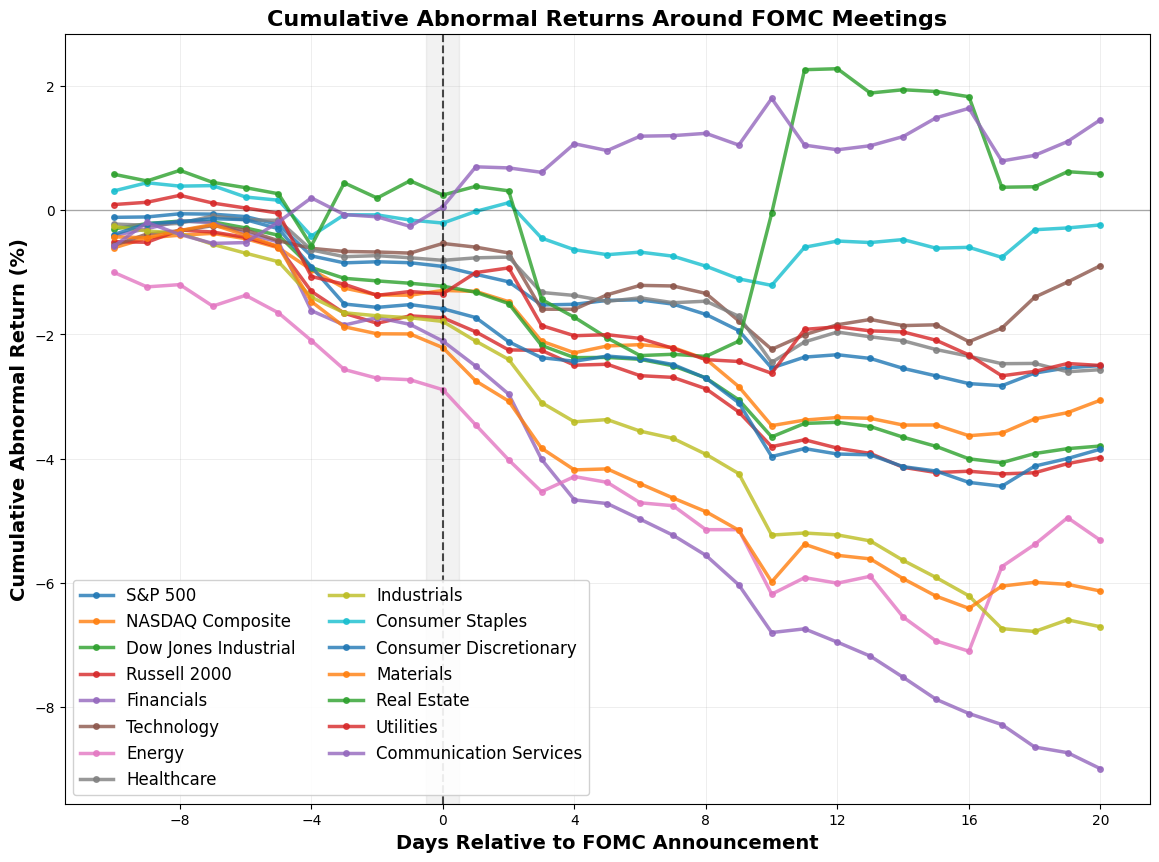

In [5]:
try:
    merged_data = pd.read_csv('data/merged_dataset.csv', index_col=0, parse_dates=True)
    print(f"Loaded merged dataset with shape: {merged_data.shape}")
    
    indices = ['SP500', 'NASDAQ', 'DowJones', 'Russell2000']
    
    sectors = ['XLF', 'XLK', 'XLE', 'XLV', 'XLI', 'XLP', 'XLY', 'XLB', 'XLRE', 'XLU', 'XLC']
    
    available_indices = [idx for idx in indices if idx in merged_data.columns]
    available_sectors = [sector for sector in sectors if sector in merged_data.columns]
    
    assets = available_indices + available_sectors
    
    if not assets:
        print("Error: No assets found in the dataset")
        exit(1)
        
    print(f"Analyzing {len(assets)} assets: {', '.join(assets)}")
    
    results = run_event_study_analysis(
        data=merged_data,
        assets=assets,
        market_index='SP500',
        event_window=(-10, 20),
        estimation_window=120,
        market_model=True,
        by_event_type=True
    )
    
    print("\nEvent study analysis complete!")
    print(f"Results saved to 'results' directory")
    print(f"Plots saved to 'plots' directory")
    
    print("\nSummary of Results:")
    if 'summary' in results:
        pd.set_option('display.max_rows', None)
        pd.set_option('display.width', 1000)
        print(results['summary'])
    
except FileNotFoundError:
    print("Error: Cannot find merged_dataset.csv. Please run data collection first.")
except Exception as e:
    print(f"Error: {str(e)}")
    import traceback
    traceback.print_exc()
    print(f"Found {len(rate_cuts[rate_cuts.index.isin(event_study.event_dates)].index.unique())} rate cut events")